In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### evaluation_ner.py

In [ ]:
from collections import OrderedDict

def _update_chunk(candidate, prev, current_tag, current_chunk, current_pos, prediction=False):
    if candidate == 'B-' + current_tag:
        if len(current_chunk) > 0 and len(current_chunk[-1]) == 1:
                current_chunk[-1].append(current_pos - 1)
        current_chunk.append([current_pos])
    elif candidate == 'I-' + current_tag:
        if prediction and (current_pos == 0 or current_pos > 0 and prev.split('-', 1)[-1] != current_tag):
            current_chunk.append([current_pos])
        if not prediction and (current_pos == 0 or current_pos > 0 and prev == 'O'):
            current_chunk.append([current_pos])
    elif current_pos > 0 and prev.split('-', 1)[-1] == current_tag:
        if len(current_chunk) > 0:
            current_chunk[-1].append(current_pos - 1)

def _update_last_chunk(current_chunk, current_pos):
    if len(current_chunk) > 0 and len(current_chunk[-1]) == 1:
        current_chunk[-1].append(current_pos - 1)

def _tag_precision_recall_f1(tp, fp, fn):
    precision, recall, f1 = 0, 0, 0
    if tp + fp > 0:
        precision = tp / (tp + fp) * 100
    if tp + fn > 0:
        recall = tp / (tp + fn) * 100
    if precision + recall > 0:
        f1 = 2 * precision * recall / (precision + recall)
    return precision, recall, f1

def _aggregate_metrics(results, total_correct):
    total_true_entities = 0
    total_predicted_entities = 0
    total_precision = 0
    total_recall = 0
    total_f1 = 0
    for tag, tag_metrics in results.items():
        n_pred = tag_metrics['n_predicted_entities']
        n_true = tag_metrics['n_true_entities']
        total_true_entities += n_true
        total_predicted_entities += n_pred
        total_precision += tag_metrics['precision'] * n_pred
        total_recall += tag_metrics['recall'] * n_true
    accuracy = total_correct / total_true_entities * 100
    total_precision = total_precision / total_predicted_entities if total_predicted_entities != 0 else 0
    total_recall = total_recall / total_true_entities
    if total_precision + total_recall > 0:
        if total_precision + total_recall >= 1e-16:
            total_f1 = 2 * total_precision * total_recall / (total_precision + total_recall)
        else:
            total_f1 = 0
    return total_true_entities, total_predicted_entities, \
           total_precision, total_recall, total_f1, accuracy

def _print_info(n_tokens, total_true_entities, total_predicted_entities, total_correct):
    print('processed {len} tokens ' \
          'with {tot_true} phrases; ' \
          'found: {tot_pred} phrases; ' \
          'correct: {tot_cor}.\n'.format(len=n_tokens,
                                         tot_true=total_true_entities,
                                         tot_pred=total_predicted_entities,
                                         tot_cor=total_correct))

def _print_metrics(accuracy, total_precision, total_recall, total_f1):
    print('precision:  {tot_prec:.2f}%; ' \
          'recall:  {tot_recall:.2f}%; ' \
          'F1:  {tot_f1:.2f}\n'.format(acc=accuracy,
                                           tot_prec=total_precision,
                                           tot_recall=total_recall,
                                           tot_f1=total_f1))

def _print_tag_metrics(tag, tag_results):
    print(('\t%12s' % tag) + ': precision:  {tot_prec:6.2f}%; ' \
                               'recall:  {tot_recall:6.2f}%; ' \
                               'F1:  {tot_f1:6.2f}; ' \
                               'predicted:  {tot_predicted:4d}\n'.format(tot_prec=tag_results['precision'],
                                                                         tot_recall=tag_results['recall'],
                                                                         tot_f1=tag_results['f1'],
                                                                         tot_predicted=tag_results['n_predicted_entities']))

class ScoreEvaluator:
	def __init__(self, token_to_idx, idx_to_tag, idx_to_token):
		self.token_to_idx = token_to_idx
		self.idx_to_tag = idx_to_tag
		self.idx_to_token = idx_to_token

	@staticmethod
	def precision_recall_f1(y_true, y_pred, print_results=True, short_report=False):
	    # Find all tagy_trues
	    tags = sorted(set(tag[2:] for tag in y_true + y_pred if tag != 'O'))

	    results = OrderedDict((tag, OrderedDict()) for tag in tags)
	    n_tokens = len(y_true)
	    total_correct = 0

	    # For eval_conll_try we find all chunks in the ground truth and prediction
	    # For each chunk we store starting and ending indices
	    for tag in tags:
	        true_chunk = list()
	        predicted_chunk = list()
	        for position in range(n_tokens):
	            _update_chunk(y_true[position], y_true[position - 1], tag, true_chunk, position)
	            _update_chunk(y_pred[position], y_pred[position - 1], tag, predicted_chunk, position, True)

	        _update_last_chunk(true_chunk, position)
	        _update_last_chunk(predicted_chunk, position)

	        # Then we find all correctly classified intervals
	        # True positive results
	        tp = sum(chunk in predicted_chunk for chunk in true_chunk)
	        total_correct += tp

	        # And then just calculate errors of the first and second kind
	        # False negative
	        fn = len(true_chunk) - tp
	        # False positive
	        fp = len(predicted_chunk) - tp
	        precision, recall, f1 = _tag_precision_recall_f1(tp, fp, fn)

	        results[tag]['precision'] = precision
	        results[tag]['recall'] = recall
	        results[tag]['f1'] = f1
	        results[tag]['n_predicted_entities'] = len(predicted_chunk)
	        results[tag]['n_true_entities'] = len(true_chunk)

	    total_true_entities, total_predicted_entities, \
	           total_precision, total_recall, total_f1, accuracy = _aggregate_metrics(results, total_correct)

	    if print_results:
	        _print_info(n_tokens, total_true_entities, total_predicted_entities, total_correct)
	        _print_metrics(accuracy, total_precision, total_recall, total_f1)

	        if not short_report:
	            for tag, tag_results in results.items():
	                _print_tag_metrics(tag, tag_results)
	    if short_report:
	    	results = {
	            'precision': total_precision,
	            'recall': total_recall,
	            'f1': total_f1,
	            'n_predicted_entities': total_predicted_entities,
	            'n_true_entities': total_true_entities,
	    	}
	    return results

	def predict_tags(self, model, token_idxs_batch):
	    """Performs predictions and transforms indices to tokens and tags."""
	    
	    tag_idxs_batch = model.predict_for_batch(token_idxs_batch)
	    tags_batch, tokens_batch = [], []
	    for tag_idxs, token_idxs in zip(tag_idxs_batch, token_idxs_batch):
	        tags, tokens = [], []
	        for tag_idx, token_idx in zip(tag_idxs, token_idxs):
	            if token_idx != self.token_to_idx['<PAD>']:
	                tags.append(self.idx_to_tag[tag_idx])
	                tokens.append(self.idx_to_token[token_idx])
	        tags_batch.append(tags)
	        tokens_batch.append(tokens)
	    return tags_batch, tokens_batch
	    
	def eval_conll(self, model, data_loader, print_results=False, short_report=True):
	    """Computes NER quality measures using CONLL shared task script."""
	    
	    y_true, y_pred = [], []
	    for x_batch, y_batch in data_loader:
	        pred_tags_batch, tokens_batch = self.predict_tags(model, x_batch)
	        ground_truth_tags = [
	        	[self.idx_to_tag[tag_idx] for tag_idx in true_tag_sequence][:len(pred_tag_sequence)]
	        	for true_tag_sequence, pred_tag_sequence in zip(y_batch, pred_tags_batch)
	        ]

	        # We extend every prediction and ground truth sequence with 'O' tag
	        # to indicate a possible end of entity.
	        for true_sequence, pred_sequence in zip(ground_truth_tags, pred_tags_batch):
	            y_true += true_sequence + ['O']
	            y_pred += pred_sequence + ['O']

	    results = self.precision_recall_f1(y_true, y_pred, print_results=print_results, short_report=short_report)
	    return results

In [ ]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
def read_data(file_path):
    tokens = []
    tags = []
    temp_token = []
    temp_tags = []
    i = 0
    with open(file_path) as f:
      for line in f:
        i+=1
        #print(line)
        if (line == "\n"):
          tokens.append(temp_token)
          tags.append(temp_tags)
          temp_token = []
          temp_tags = []
        else:

          arr = line.split()
          #print(arr)
          try:
            elem = arr[0]
          except:
            raise Exception(i)
          if (arr[0][0] == "@"):
            elem = "<USR>"
          if (arr[0].startswith("http://") or arr[0].startswith("https://")):
            elem = "<URL>"
          
          temp_token.append(elem)
          temp_tags.append(arr[1])



    

    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    return tokens, tags

In [ ]:
train_sentences, train_tags = read_data('/content/drive/My Drive/twitter_ner_data.zip (Unzipped Files)/data/train.txt')
val_sentences, val_tags = read_data('/content/drive/My Drive/twitter_ner_data.zip (Unzipped Files)/data/validation.txt')
test_sentences, test_tags = read_data('/content/drive/My Drive/twitter_ner_data.zip (Unzipped Files)/data/test.txt')

In [ ]:
for i in range(3):
    for token, one_tag in zip(train_sentences[i], train_tags[i]):
        print('%s\t%s' % (token, one_tag))
    print()

RT	O
<USR>	O
:	O
Online	O
ticket	O
sales	O
for	O
Ghostland	B-musicartist
Observatory	I-musicartist
extended	O
until	O
6	O
PM	O
EST	O
due	O
to	O
high	O
demand	O
.	O
Get	O
them	O
before	O
they	O
sell	O
out	O
...	O

Apple	B-product
MacBook	I-product
Pro	I-product
A1278	I-product
13.3	I-product
"	I-product
Laptop	I-product
-	I-product
MD101LL/A	I-product
(	O
June	O
,	O
2012	O
)	O
-	O
Full	O
read	O
by	O
eBay	B-company
<URL>	O
<URL>	O

Happy	O
Birthday	O
<USR>	O
!	O
May	O
Allah	B-person
s.w.t	O
bless	O
you	O
with	O
goodness	O
and	O
happiness	O
.	O



In [ ]:
def build_dict(entities, special_entities):
    """
    Args:
        entities: a list of lists of tokens or tags
        special_entities: some special tokens
        
    Returns:
        entity_to_idx : mapping to index  
        idx_to_entity : mapping from index
    """

    entity_to_idx = dict()
    idx_to_entity = []



    
    # Create mappings from tokens to indices and vice versa
    # Add special tokens to dictionaries
    # The first special token must have index 0

    #PAD_length = max(len(elem) for elem in entities)
    for i in entities:
      for j in i:
        if j not in idx_to_entity:
          idx_to_entity.append(j)

    idx_to_entity = special_entities + idx_to_entity
    entity_to_idx = {word: i for i, word in enumerate(idx_to_entity)}
    ######################################
    ######### YOUR CODE HERE #############
    ######################################
    
    return entity_to_idx, idx_to_entity

In [ ]:
special_tokens = ['<UNK>', '<PAD>']
special_tags = []

# Create dictionaries 
token_to_idx, idx_to_token = build_dict(train_sentences + val_sentences, special_tokens)
tag_to_idx, idx_to_tag = build_dict(train_tags, special_tags)

In [ ]:
from torch.utils.data import Dataset, DataLoader


class TaggingDataset(Dataset):
    
    def __init__(self, sentences, tags, token_to_idx, tag_to_idx):
        """
        Args:
            sentences: a list of lists of tokens or tags
            tags: some special tokens
            token_to_idx: mapping from token to token indexes
            tag_to_idx: mapping from tag to tag indexes
        """
        super().__init__()
        self._sentences = [ list([ j if j in token_to_idx else "<UNK>" for j in l ]) for l in sentences ]
        self._tags = tags
        self._token_to_idx = token_to_idx
        self._tag_to_idx = tag_to_idx
        
        
        ######################################
        ######### YOUR CODE HERE #############
        ######################################
        
    def __getitem__(self, idx):
        """
        Args:
            idx : int
            
        Returns:
            sentence_idx : torch.tensor of token indexes
            tag_idx : torch.tensor of tag indexes
        """

        #print(len(self._sentences[idx]))
        #print(len(self._tags[idx]))

        #print("After")
        tokens = torch.Tensor([self._token_to_idx[i] for i in self._sentences[idx]]).int()
        #print(self._sentences[idx])
        tags = torch.Tensor([self._tag_to_idx[i] for i in self._tags[idx]]).int()
        #print(tokens.size())
        #print(tags.size())
        return tokens, tags 
        


        ######################################
        ######### YOUR CODE HERE #############
        ######################################
    
    def __len__(self):
      return len(self._sentences)
        ######################################
        ######### YOUR CODE HERE #############
        ######################################


In [ ]:
from torch.nn.utils.rnn import pad_sequence


class PaddingCollator:
    def __init__(self,  pad_token_id, pad_tag_id, batch_first=True):
        self.pad_token_idx = pad_token_id
        self.pad_tag_id = pad_tag_id
        self.batch_first = batch_first
        
    def __call__(self, batch):
        """
        Args:
            batch: list of tuples of torch.tensors
        
        Returns:
            new_sentences: torch.tensor
            new_tags: torch.tensor
                Both tensors have the same size 
        """
        ######################################
        ######### YOUR CODE HERE #############
        ######################################
       
        token,tag = zip(*batch)
        token_pad = pad_sequence(token, self.batch_first, self.pad_token_idx)
        tag_pad =  pad_sequence(tag,self.batch_first,self.pad_tag_id)

        return token_pad.long(), tag_pad.long()



In [ ]:
small_dataset = TaggingDataset(
    sentences=train_sentences[:7],
    tags=train_tags[:7],
    token_to_idx=token_to_idx,
    tag_to_idx=tag_to_idx,
)

small_loader = DataLoader(
    small_dataset,
    batch_size=3,
    shuffle=False,
    drop_last=False,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)

batch_lengths = [3, 3, 1]
sequence_lengths = [26, 25, 8]
some_pad_tensor = torch.LongTensor([token_to_idx['<PAD>']] * 12)
some_outside_tensor = torch.LongTensor([[tag_to_idx['O']] * 12])

for i, (tokens_batch, tags_batch) in enumerate(small_loader):
    assert tokens_batch.dtype == torch.int64, 'tokens_batch is not LongTensor'
    assert tags_batch.dtype == torch.int64, 'tags_batch is not LongTensor'
    
    assert len(tokens_batch) == batch_lengths[i], 'wrong batch length'
    
    for one_token_sequence in tokens_batch:
        assert len(one_token_sequence) == sequence_lengths[i], 'wrong length of sequence in batch'
    
    if i == 0:
        assert torch.all(tokens_batch[2][-12:] == some_pad_tensor), "wrong padding"       
        assert torch.all(tags_batch[2][-12:] == some_outside_tensor), "wrong O tag"

In [ ]:
######################################
######### YOUR CODE HERE #############
######################################
#  TRAIN DATALOADER
train_dataset = TaggingDataset(
    sentences=train_sentences,
    tags=train_tags,
    token_to_idx=token_to_idx,
    tag_to_idx=tag_to_idx,
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)

# VALIDATION DATALOADER
validation_dataset = TaggingDataset(
    sentences=val_sentences,
    tags=val_tags,
    token_to_idx=token_to_idx,
    tag_to_idx=tag_to_idx,
)

validation_loader = DataLoader(
    validation_dataset,
    batch_size=64,
    shuffle=True,
    drop_last=True,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)

# TEST DATALOADER
test_dataset = TaggingDataset(
    sentences=test_sentences,
    tags=test_tags,
    token_to_idx=token_to_idx,
    tag_to_idx=tag_to_idx,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=4,
    shuffle=True,
    drop_last=True,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)

In [ ]:
class BiLSTMModel(torch.nn.Module):
    def __init__(
        self,
        vocabulary_size,
        tag_space_size,
        pad_token_idx,
        embedding_dim,
        lstm_hidden_size,
        dropout_zeroed_probability,
        device='cpu'
    ):
        '''
        Defines neural network structure.
        
        architecture: input -> Embedding -> BiLSTM with Dropout -> Linear
        
        ----------
        Parameters
        
        vocabulary_size: int, number of words in vocabulary.
        tag_space_size: int, number of tags.
        pad_token_idx: int, index of padding character. Used for loss masking.
        embedding_dim: int, dimension of words' embeddings.
        lstm_hidden_size: int, number of hidden units in each LSTM cell
        dropout_zeroed_probability: float, dropout zeroed probability for Dropout layer.
        device: str, cpu or cuda:x
        '''
        super().__init__()
        self.embedding = nn.Embedding(vocabulary_size, embedding_dim, padding_idx=pad_token_idx)
        self.bilstm = nn.LSTM(embedding_dim, hidden_size=lstm_hidden_size, bidirectional = True)
        self.device = device
        self.dropout = nn.Dropout(dropout_zeroed_probability)
        self.linear = nn.Linear(2 * lstm_hidden_size, tag_space_size)
        ######################################
        ######### YOUR CODE HERE #############
        ######################################        

        
    def forward(self, x_batch):
        '''
        Makes forward pass.
        
        ----------
        Parameters
        x_batch: torch.LongTensor with shape (number of samples in batch, number words in sentence).
        '''
        x_batch = torch.LongTensor(x_batch)
        out = self.embedding(x_batch)
        out, _ = self.bilstm(out)
        out = self.dropout(out)
        pred_scores = self.linear(out)
        #pred_probs = nn.LogSoftmax(pred_scores, dim=2)
        return pred_scores


        ######################################
        ######### YOUR CODE HERE #############
        ######################################        
    
    def predict_for_batch(self, x_batch):
        '''
        Returns predictions for x_batch. Use argmax function.
        
        return type: torch.LongTensor
        return shape: (number of samples in batch, number words in sentence.
        
        ----------
        Parameters
        x_batch: torch.LongTensor with shape (number of samples in batch, number words in sentence).
        '''
        ######################################
        ######### YOUR CODE HERE #############
        ######################################   
        with torch.no_grad():
          pred_probs = self.forward(x_batch)
          pred_probs  = nn.functional.log_softmax(pred_probs, dim = 2)
          pred_tags = torch.argmax(pred_probs, dim = 2)
        
        return pred_tags


    def predict_for_batch_crf(self, x_batch):
        '''
        Returns predictions for x_batch. Use argmax function.
        
        return type: torch.LongTensor
        return shape: (number of samples in batch, number words in sentence.
        
        ----------
        Parameters
        x_batch: torch.LongTensor with shape (number of samples in batch, number words in sentence).
        '''
        ######################################
        ######### YOUR CODE HERE #############
        ######################################   
        with torch.no_grad():
          pred_probs = self.forward(x_batch)
          pred_probs  = nn.functional.log_softmax(pred_probs, dim = 2)
          #pred_tags = torch.argmax(pred_probs, dim = 2)
        
        return pred_probs  

In [ ]:
#from evaluation_ner import ScoreEvaluator

evaluator = ScoreEvaluator(
    token_to_idx=token_to_idx,
    idx_to_tag=idx_to_tag,
    idx_to_token=idx_to_token,
)

In [ ]:
!pip install barbar
from barbar import Bar
from tqdm import tqdm
from torch.optim import Adam
#import pytorch_warmup as warmup


In [ ]:
######################################
######### YOUR CODE HERE #############
######################################    


model = BiLSTMModel(len(token_to_idx),
                    len(tag_to_idx),
                    token_to_idx['<PAD>'],
                    embedding_dim= 150,
                    lstm_hidden_size= 200,
                    dropout_zeroed_probability= 0.5,
                    device = 'cpu' )

loss = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.01,weight_decay=1e-5)
epoch = 20


In [ ]:

def train_model(model, loss, optimizer, epoch, device = 'cpu'):
  

  num_steps = len(train_loader) * epoch
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps)
  #warmup_scheduler = warmup.UntunedLinearWarmup(optimizer)
  all_losses_train = []
  all_losses_test = []
  #device ='cuda'
  #model.to('cpu')
  print(device)
  model.to(device)
  model.train()
  #scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: epoch / 1.1)
  for n_epoch in (range(epoch)):
      #train part
      
     
      mean_loss_train = 0.0
      mean_loss_test = 0.0
      print(" Epoch: {0}/{1}".format(n_epoch+1, epoch))
      print('-' * 10)
      print("TRAIN FAZE:")
      #scheduler.step()
      #print("LR: ",scheduler.get_lr()[0])
      for token, tag  in (tqdm(train_loader,position=0, leave=True)): 

          token = token.to(device)
          tag = tag.to(device)
          optimizer.zero_grad()

          outputs = model(token)

          loss_value = loss(outputs.permute(0,2,1), tag)
          mean_loss_train += loss_value.to('cpu')
          loss_value.backward()

          #clipping_value = 2 # arbitrary value of your choosing
          #torch.nn.utils.clip_grad_norm(model.parameters(), clipping_value)  
          
          optimizer.step()
          lr_scheduler.step()
          #warmup_scheduler.dampen()
          
          
          



        
      epoch_loss_train = mean_loss_train/len(train_loader)
      print(" Loss Train: {0}".format(epoch_loss_train))
      
      all_losses_train.append(epoch_loss_train)

  import matplotlib.pyplot as plt
  plt.plot(all_losses_train,'r')
  #plt.plot(all_losses_test,'g')
  line_up, = plt.plot(all_losses_train, "r", label='train')
  #line_down, = plt.plot(all_losses_test, "g", label='test')
  plt.legend(handles=[line_up])
  plt.show()


  model.to('cpu')
  with torch.no_grad():
        model.eval()
        print("Train metrics")
        evaluator.eval_conll(model,train_loader,print_results=True,short_report=True)

        print("Test metrics")
        evaluator.eval_conll(model,test_loader,print_results=True,short_report=True)

        print("Validation metrics")
        evaluator.eval_conll(model,validation_loader,print_results=True,short_report=True)




  0%|          | 0/181 [00:00<?, ?it/s]

cpu
 Epoch: 1/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:27,  6.66it/s]

 Loss Train: 0.29686418175697327
 Epoch: 2/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:27,  6.63it/s]

 Loss Train: 0.192129448056221
 Epoch: 3/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:25,  6.98it/s]

 Loss Train: 0.13244137167930603
 Epoch: 4/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:25,  6.98it/s]

 Loss Train: 0.10057751089334488
 Epoch: 5/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:25,  7.13it/s]

 Loss Train: 0.08753395825624466
 Epoch: 6/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:25,  7.13it/s]

 Loss Train: 0.08214685320854187
 Epoch: 7/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:30,  5.96it/s]

 Loss Train: 0.07866158336400986
 Epoch: 8/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:30,  5.95it/s]

 Loss Train: 0.07464296370744705
 Epoch: 9/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:30,  5.88it/s]

 Loss Train: 0.07117990404367447
 Epoch: 10/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:28,  6.37it/s]

 Loss Train: 0.06816837936639786
 Epoch: 11/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:30,  5.89it/s]

 Loss Train: 0.06511998176574707
 Epoch: 12/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:29,  6.16it/s]

 Loss Train: 0.06327037513256073
 Epoch: 13/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:27,  6.61it/s]

 Loss Train: 0.059832535684108734
 Epoch: 14/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:27,  6.47it/s]

 Loss Train: 0.058265168219804764
 Epoch: 15/20
----------
TRAIN FAZE:


  0%|          | 0/181 [00:00<?, ?it/s]

 Loss Train: 0.05564968287944794
 Epoch: 16/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:28,  6.27it/s]

 Loss Train: 0.05501915141940117
 Epoch: 17/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:29,  6.07it/s]

 Loss Train: 0.052479326725006104
 Epoch: 18/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:27,  6.63it/s]

 Loss Train: 0.05110986903309822
 Epoch: 19/20
----------
TRAIN FAZE:


  1%|          | 1/181 [00:00<00:28,  6.39it/s]

 Loss Train: 0.050276339054107666
 Epoch: 20/20
----------
TRAIN FAZE:


100%|██████████| 181/181 [00:28<00:00,  6.25it/s]


 Loss Train: 0.04933681711554527


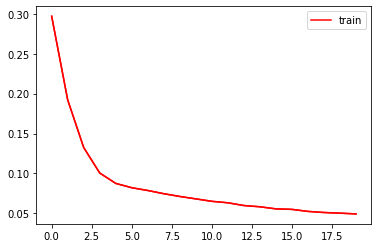

Train metrics
processed 105737 tokens with 4487 phrases; found: 5187 phrases; correct: 3190.

precision:  61.50%; recall:  71.09%; F1:  65.95

Test metrics
processed 13258 tokens with 604 phrases; found: 448 phrases; correct: 195.

precision:  43.53%; recall:  32.28%; F1:  37.07

Validation metrics
processed 12473 tokens with 526 phrases; found: 382 phrases; correct: 166.

precision:  43.46%; recall:  31.56%; F1:  36.56



In [ ]:
train_model(model, loss,optimizer, epoch, device = 'cpu')

In [ ]:
'''with torch.no_grad():
  i = 3
  model.eval()
  t = validation_dataset[i][0].long()
  print(val_sentences[i])
  #print(validation_dataset[0][0])
  #print(train_dataset[0])
  temp_ouput = model.predict_for_batch(t.unsqueeze(0)).tolist()[0]
  print(temp_ouput)
  answer = [   idx_to_tag[i]  for i in temp_ouput]
  print(answer)
  print(validation_dataset[i][1])'''


'with torch.no_grad():\n  i = 3\n  model.eval()\n  t = validation_dataset[i][0].long()\n  print(val_sentences[i])\n  #print(validation_dataset[0][0])\n  #print(train_dataset[0])\n  temp_ouput = model.predict_for_batch(t.unsqueeze(0)).tolist()[0]\n  print(temp_ouput)\n  answer = [   idx_to_tag[i]  for i in temp_ouput]\n  print(answer)\n  print(validation_dataset[i][1])'

In [ ]:
'''
model.eval()
torch.save(model.state_dict(), "/content/model.pt")

model = model = BiLSTMModel(len(token_to_idx),
                    len(tag_to_idx),
                    token_to_idx['<PAD>'],
                    embedding_dim= 150,
                    lstm_hidden_size= 180,
                    dropout_zeroed_probability= 0.5,
                    device = 'cpu' )

model.load_state_dict(torch.load("/content/model.pt"))
model.eval()'''

'\nmodel.eval()\ntorch.save(model.state_dict(), "/content/model.pt")\n\nmodel = model = BiLSTMModel(len(token_to_idx),\n                    len(tag_to_idx),\n                    token_to_idx[\'<PAD>\'],\n                    embedding_dim= 150,\n                    lstm_hidden_size= 180,\n                    dropout_zeroed_probability= 0.5,\n                    device = \'cpu\' )\n\nmodel.load_state_dict(torch.load("/content/model.pt"))\nmodel.eval()'

In [ ]:
from collections import Counter
from itertools import combinations_with_replacement
import math

class ViterbiPostprocesser:    
    def __init__(self, model, smoothing=1.0, w=1.0):
        """
        model : torch.nn.Module
            Tagging model
        smoothing : float, constant in add-k-smoothing
        w : feature weight
             Use w for first feature weight and (1 - w) for second feature.
        """
        self.model = model
        self.smoothing = smoothing
        self.w1 = w
        self.w2 = 1-w
        self.A = 0
        self.C = 0
        self.tags_ar = 0

        self.increm = 1
        
        
    def fit(self, dataset):
        """
        Fit the model using maximum likelihood method.
        
        dataset: torch.dataset
            One element if pair (sentence, tags) 
        """
        ######################################
        ######### YOUR CODE HERE #############
        ######################################  
        token,tag = zip(*dataset)

        self.tags_ar  = torch.unique(torch.cat(list(tag))).tolist()
        
        self.A = torch.zeros([len(self.tags_ar), len(self.tags_ar)], dtype=torch.float64)
        #print(self.A)
        list_pairs = list(combinations_with_replacement(self.tags_ar,2))
        #print(list_pairs)
        sequence = torch.cat(list(tag)).tolist()
        #print(sequence)
        c = dict(Counter(zip(sequence, sequence[1:])))
        #print(dict(c))
        #[1, 2, 3, 4, 1, 4, 1].count(1)  
        for i,j in list_pairs:
            
            if (i==j):

              if ((i,j) in c):
                counts = c[(i,j)]
              else:
                counts = 0.0

              self.A[i][j] = (counts+self.smoothing)/(sequence.count(j) + len(sequence)*self.smoothing)
              
            else: 
              
              if ((j,i) in c):
                counts = c[(j,i)]
              else:
                counts = 0.0

              self.A[i][j] = (counts+self.smoothing)/(sequence.count(j) + len(sequence)*self.smoothing)

              if ((i,j) in c):
                counts = c[(i,j)]
              else:
                counts = 0.0

              self.A[j][i] = (counts+self.smoothing)/(sequence.count(i) + len(sequence)*self.smoothing)

        self.C = [sequence.count(i)/len(sequence) for i in self.tags_ar] 

        #print(self.A)
        #print(self.C)

        
    def decode(self, model_logprobs):
        """
        Viterbi decoding for input model output
        
        model_logprobs : torch.tensor
            Shape is (sequence_length, tag_space_size) 
        """
        #print(model_logprobs.shape)
        sequence_length = list(model_logprobs.shape)[0]
        tag_space_size = list(model_logprobs.shape)[1]
        #print(model_logprobs.shape)
        #print(sequence_length)
        #print(tag_space_size)

        def f1(y,i):
          return model_logprobs[i][y]
        
        def f2(x,y,i):
          return math.log(self.C[y]) if i<1 else math.log(self.A[x][y])


        
        def G(u,v,k):
          return self.w1 * f1(v,k)+ self.w2 * f2(u,v,k)

        def straight_step(i,j,U_row):
          arr_proba = []
          for elem in self.tags_ar:
            arr_proba.append(G(elem,j,i)+U_row[elem])
          return max(arr_proba)
                  
        U = torch.zeros([sequence_length+1, tag_space_size], dtype=torch.float64)

        for i in range(1,sequence_length+1):
          for j in range(0,tag_space_size):
            U[i,j] = straight_step(i-1,j,U[i-1])

        final_tag_ids = [-1]

        def reverse_step(U_row, flag_it, previous_tag_final, increment):
          arr_max = []
          if (flag_it):
            values, indices = torch.max(U_row, 0)
            return indices.item()
          else:
            for i in self.tags_ar:
              arr_max.append(U_row[i]+G(i,previous_tag_final,increment+1))
            values, indices = torch.max(torch.Tensor(arr_max), 0)
            return indices.item()
            
            
        flag_check = True
        for tag_inc in reversed(range(1,sequence_length+1)):
          tmp = reverse_step(U[tag_inc], flag_check, final_tag_ids[-1], tag_inc-1)
          final_tag_ids.append(tmp)
          flag_check = False

        final_tag_ids.reverse()
        tmp_res = final_tag_ids[:-1]
        #print(torch.Tensor(tmp_res).shape)

        
        return torch.Tensor(tmp_res)



        ######################################
        ######### YOUR CODE HERE #############
        ######################################        
    
    def predict_for_batch(self, x_batch):
        """
        Returns predictions for x_batch. Use viterbi decoding.
        
        return type: torch.LongTensor
        return shape: (number of samples in batch, number words in sentence.
        
        ----------
        Parameters
        x_batch: torch.LongTensor with shape (number of samples in batch, number words in sentence).
        """


        ######################################
        ######### YOUR CODE HERE #############
        ###################################### 
        self.model.eval()
        with torch.no_grad():
          #result_tensor = torch.zeros([x_batch.size(0), x_batch.size(1)], dtype=torch.float64)
          tensor_ar = []
          
          output = self.model.predict_for_batch_crf(x_batch)
          for i in output:
            tensor_ar.append(self.decode(i))
          result = torch.stack(tensor_ar).long()
          #print(result.shape)
          #print(x_batch.shape)
         # print("Batch {} passed".format(self.increm))
          self.increm+=1
          
          
          return result      

Место для ваших экспериментов:

In [ ]:
VP = ViterbiPostprocesser(model,smoothing=1.0,w = 0.99)
VP.fit(train_dataset)
#print("Train metrics")
#evaluator.eval_conll(VP,train_loader,print_results=True,short_report=True)

print("Test metrics")
evaluator.eval_conll(VP,test_loader,print_results=True,short_report=True)

print("Validation metrics")
evaluator.eval_conll(VP,validation_loader,print_results=True,short_report=True)
  
    ######################################
    ######### YOUR CODE HERE #############
    ######################################       

Test metrics
Batch 1 passed
Batch 2 passed
Batch 3 passed
Batch 4 passed
Batch 5 passed
Batch 6 passed
Batch 7 passed
Batch 8 passed
Batch 9 passed
Batch 10 passed
Batch 11 passed
Batch 12 passed
Batch 13 passed
Batch 14 passed
Batch 15 passed
Batch 16 passed
Batch 17 passed
Batch 18 passed
Batch 19 passed
Batch 20 passed
Batch 21 passed
Batch 22 passed
Batch 23 passed
Batch 24 passed
Batch 25 passed
Batch 26 passed
Batch 27 passed
Batch 28 passed
Batch 29 passed
Batch 30 passed
Batch 31 passed
Batch 32 passed
Batch 33 passed
Batch 34 passed
Batch 35 passed
Batch 36 passed
Batch 37 passed
Batch 38 passed
Batch 39 passed
Batch 40 passed
Batch 41 passed
Batch 42 passed
Batch 43 passed
Batch 44 passed
Batch 45 passed
Batch 46 passed
Batch 47 passed
Batch 48 passed
Batch 49 passed
Batch 50 passed
Batch 51 passed
Batch 52 passed
Batch 53 passed
Batch 54 passed
Batch 55 passed
Batch 56 passed
Batch 57 passed
Batch 58 passed
Batch 59 passed
Batch 60 passed
Batch 61 passed
Batch 62 passed
Batc

{'f1': 37.36017897091723,
 'n_predicted_entities': 373,
 'n_true_entities': 521,
 'precision': 44.77211796246649,
 'recall': 32.05374280230326}

Улучшение результатов на целый процент!! По F1 мере для теста и валидации !!!

In [ ]:
valida = TaggingDataset(
    sentences=val_sentences[:10],
    tags=val_tags[:10],
    token_to_idx=token_to_idx,
    tag_to_idx=tag_to_idx,
)

valida_loader = DataLoader(
    valida,
    batch_size=10,
    shuffle=False,
    drop_last=False,
    collate_fn=PaddingCollator(
        pad_token_id=token_to_idx['<PAD>'],
        pad_tag_id=tag_to_idx['O'],
        batch_first=True,
    ),
)

for i,j in valida_loader:
  output = VP.predict_for_batch(i)
k = 4

print(val_tags[k])
print(j[k])
print("compare")
print(output[k])


Batch 206 passed
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-other', 'O']
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])
compare
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0])


In [ ]:

#fit part
'''
token,tag = zip(*train_dataset)
tags_ar  = torch.unique(torch.cat(list(tag)))
print(type(tags_ar))


from itertools import combinations
token,tag = zip(*train_dataset)
tags_ar  = torch.unique(torch.cat(list(tag))).tolist()
A = torch.zeros([len(tags_ar), len(tags_ar)], dtype=torch.float64)
list_pairs = list(combinations_with_replacement(tags_ar,2))
print(list_pairs)
from collections import Counter
sequence = torch.cat(list(tag)).tolist()[:10]
#print(sequence)
c = Counter(zip(sequence, sequence[1:]))
print(dict(c))
[1, 2, 3, 4, 1, 4, 1].count(1)

#print(sequence.count(tags_ar[1]))
C_matrix = [sequence.count(i)/len(sequence) for i in tags_ar] 
print(C_matrix)
'''
